<a href="https://colab.research.google.com/github/WellFan/bayesian_with_merchants/blob/main/merchants_goods_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy import stats
import stan
import arviz as az
!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


---

Consider the following model:

$\mu_i\sim Beta(\alpha_u, \beta_u)\\
trial_i\sim Gamma(10,10)$


With parameter tranformation:

$\alpha_i=\mu_i*trial_i\\
\beta_i=(1-\mu_i)*trial_i$

The relation between datas and parameters:

$ctr_{ij}\sim Beta(\alpha_i, \beta_i)\\
click_{ij}\sim Bin(impression_{ij}, ctr_{ij})\\
impression_{ij}-1\sim Poisson(\lambda=1000*\mu_i+5)$

Let i denote the i'th merchant, let (i,j) denote the j'th kind of goods from i'th merchant

---

In [2]:
nmerchants = 100
ngoods = np.random.randint(low=1, high=101, size=nmerchants)
alpha_u = 2
beta_u = 98
mu_i = stats.beta.rvs(alpha_u, beta_u, size=nmerchants)
trial = stats.gamma.rvs(10, scale=10, size=nmerchants)
true_parameters = {'alpha_u':alpha_u, 'beta_u':beta_u, 'mu_i':mu_i, 'trial':trial, 'ngoods':ngoods, 'alpha_i':mu_i*trial, 'beta_i':(1-mu_i)*trial}
data = np.array(([0], [0], [0], [0]))
for i in range(nmerchants):
  ctr = np.array(stats.beta.rvs(mu_i[i]*trial[i], (1-mu_i[i])*trial[i], size=ngoods[i]))
  impression = stats.poisson.rvs(mu=int(1000*mu_i[i]+5)+1, size=ngoods[i])
  click = np.array(stats.binom.rvs(impression, ctr))
  merchants_id = np.array([i]*ngoods[i])
  temp = (np.vstack((merchants_id, ctr, impression, click)))
  data = np.hstack((data, temp))
data = np.transpose(data)
data = np.delete(data, 0, 0)

In [3]:
data = np.delete(data, 0, 0)
data.shape

(5033, 4)

In [4]:
text='''
data{
  int<lower=0> N;
  int<lower=0> M;
  int<lower=1, upper=100> type[N];
  int<lower=0> impression[N];
  int<lower=0> click[N];
}
parameters{
  vector<lower=0.01, upper=1>[M] mu;
  vector<lower=0>[M] trial;
  real<lower=0> alpha_u;
  real<lower=0> beta_u;
}
transformed parameters{
  vector[M] alpha_i;
  vector[M] beta_i;
  alpha_i = mu.*trial;
  beta_i = (1-mu).*trial;
}
model{
  alpha_u~uniform(0.01, 100);
  beta_u~uniform(0.01, 100);
  mu~beta(alpha_u, beta_u);
  trial~gamma(10, 0.1);
  for(i in 1:N) {
    click[i]~beta_binomial(impression[i], alpha_i[type[i]], beta_i[type[i]]);
  }
}
'''
stan_data = {'N':data.shape[0], 'M':nmerchants, 'type': list(data[:,0].astype('int')+1), 'impression': list(data[:,2].astype('int')), 'click': list(data[:,3].astype('int'))}
posterior = stan.build(text, data=stan_data)
fit = posterior.sample(num_chains=1, num_samples=500)
df = fit.to_frame()

Building...



Building: 44.4s, done.Messages from stanc:
Warning in '/tmp/httpstan_t67uv_hh/model_7oojran7.stan', line 23, column 23: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_t67uv_hh/model_7oojran7.stan', line 23, column 17: Argument 0.01 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_t67uv_hh/model_7oojran7.stan', line 23, column 2: Parameter beta_u is given a uniform distribution. The uniform distribution is not recommended, for two reasons: (a) Except when there are logical or physical constraints, it is very unusual for you to be sure that a parameter will fall inside a specified range, and (b) The infinite gradient induced by a uniform density can cause difficulties for Stan's sampling algorithm. As a consequence, we recommend soft constraints rather than hard constraints; 

In [5]:
df.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu.1,mu.2,mu.3,...,beta_i.91,beta_i.92,beta_i.93,beta_i.94,beta_i.95,beta_i.96,beta_i.97,beta_i.98,beta_i.99,beta_i.100
draws,,,,,,,,,,,,,,,,,,,,,
0,-11798.062293,0.666667,0.164091,1.0,3.0,1.0,11918.685857,0.012701,0.011011,0.024842,...,66.960389,78.356643,98.999288,76.475673,169.619416,71.073789,49.099276,114.971778,89.637428,112.406877
1,-11798.398844,0.833333,0.164091,2.0,6.0,1.0,11899.497514,0.013497,0.011163,0.023993,...,57.393971,79.871637,90.840970,69.618923,184.925426,57.848256,51.627259,107.848593,113.585554,116.064249
2,-11794.355010,0.845217,0.164091,3.0,8.0,1.0,11910.002262,0.014964,0.013269,0.020422,...,41.733661,84.098454,80.302604,73.505098,145.029013,68.113912,42.025156,116.663906,86.859474,138.355652
3,-11792.175734,0.870346,0.164091,3.0,8.0,1.0,11891.128788,0.023010,0.015842,0.021298,...,36.180629,84.141647,79.839986,77.165081,164.213251,80.228551,49.713025,129.188691,105.297641,133.292944
4,-11796.777254,0.718940,0.164091,3.0,9.0,1.0,11916.550488,0.023296,0.014978,0.021599,...,37.876238,86.406472,82.184786,74.614821,162.823054,76.748335,47.211846,118.606542,105.823659,140.029395


---

After the estimation, Stan brings lots of draws of $\hat{\alpha_u},\hat{\beta_u},\hat{\mu_i},\hat{trial_i}$

And from sample distribution

$\hat{\alpha_u}\stackrel{p}{\to}\alpha_u\\
\hat{\beta_u}\stackrel{p}{\to}\beta_u\\
\bar{\hat{\mu_i}}\stackrel{p}{\to}\mu_i\sim Beta(\alpha_\mu, \beta_\mu)\\
\bar{\hat{trial_i}}\stackrel{p}{\to}trial_i\sim Gamma(10, 10)$

---

In [6]:
df.iloc[:,107:207].mean()

parameters
trial.1      105.108945
trial.2       96.734179
trial.3       89.870173
trial.4       96.251941
trial.5       94.082343
                ...    
trial.96      95.518670
trial.97      88.969464
trial.98     101.125361
trial.99     105.103787
trial.100    109.565597
Length: 100, dtype: float64

In [7]:
alpha_u = df['alpha_u']
beta_u = df['beta_u']
mu = df.iloc[:,7:107]
trial = df.iloc[:,107:207]
alpha_i = df.iloc[:, 209:309]
beta_i = df.iloc[:, 309:409]

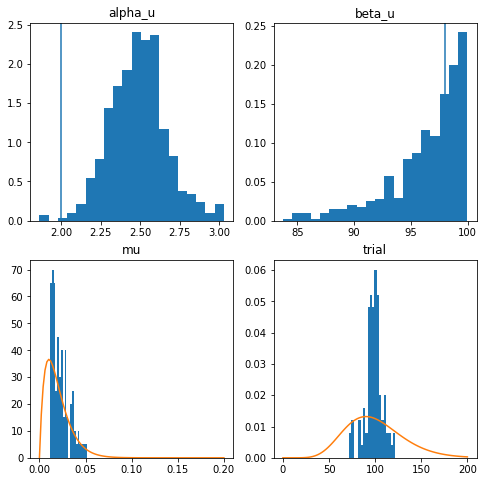

In [8]:
points = np.linspace(0, 100, 1001, endpoint=True)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axes[0,0].set_title('alpha_u')
axes[0,0].hist(alpha_u, density=True, bins=20)
axes[0,0].axvline(2)
axes[0,1].set_title('beta_u')
axes[0,1].hist(beta_u, density=True, bins=20)
axes[0,1].axvline(98)
axes[1,0].set_title('mu')
axes[1,0].hist(mu.mean(), density=True, bins=20)
axes[1,0].plot(np.linspace(0, 0.2, 100), stats.beta.pdf(np.linspace(0, 0.2, 100), 2, 98))
axes[1,1].set_title('trial')
axes[1,1].hist(trial.mean(), density=True, bins=20)
axes[1,1].plot(np.linspace(0, 200, 100), stats.gamma.pdf(np.linspace(0, 200, 100), a=10, scale=10))

In [9]:
customer_stan = pd.DataFrame(data, columns=['merchant_id', 'ctr', 'impression', 'click'])
customer_stan = customer_stan.astype({'merchant_id':int, 'impression':int, 'click':int})
customer_stan.head()

,merchant_id,ctr,impression,click
0,0,0.010092,34,1
1,0,0.031432,29,0
2,0,0.024963,34,2
3,0,0.024978,34,1
4,0,0.037996,33,0


In [10]:
customer_stan['alpha_i'] = alpha_i.mean()[customer_stan.merchant_id][1]
customer_stan['beta_i'] = beta_i.mean()[customer_stan.merchant_id][1]
customer_stan = customer_stan.assign(avg_stan = lambda df:(df.click+df.alpha_i)/(df.impression+df.alpha_i+df.beta_i))
customer_stan.head()

,merchant_id,ctr,impression,click,alpha_i,beta_i,avg_stan
0,0,0.010092,34,1,2.463468,102.645478,0.024898
1,0,0.031432,29,0,2.463468,102.645478,0.018369
2,0,0.024963,34,2,2.463468,102.645478,0.032086
3,0,0.024978,34,1,2.463468,102.645478,0.024898
4,0,0.037996,33,0,2.463468,102.645478,0.017837


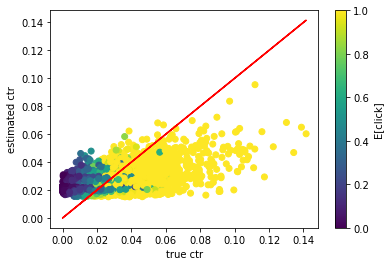

In [11]:
plt.scatter(customer_stan.ctr, customer_stan.avg_stan, c=customer_stan.impression*customer_stan.ctr, cmap='viridis', vmin=0, vmax=1)
plt.plot(customer_stan.ctr, customer_stan.ctr, color='red')
plt.xlabel('true ctr')
plt.ylabel('estimated ctr')
plt.colorbar(label='E[click]')
plt.show()

In [12]:
customer_stan.ctr.corr(customer_stan.avg_stan)

0.5994459349411301

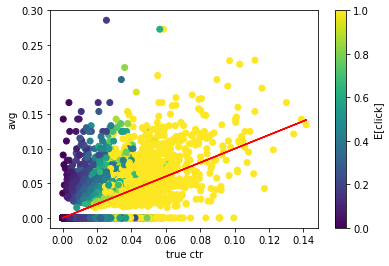

In [13]:
plt.scatter(customer_stan.ctr, customer_stan.click/customer_stan.impression, c=customer_stan.impression*customer_stan.ctr, cmap='viridis', vmin=0, vmax=1)
plt.plot(customer_stan.ctr, customer_stan.ctr, color='red')
plt.xlabel('true ctr')
plt.ylabel('avg')
plt.colorbar(label='E[click]')
plt.show()

In [14]:
print('MSE of estimated ctr per good', np.square(customer_stan.ctr-customer_stan.avg_stan).mean())
print('MSE of average ctr per good', np.square(customer_stan.ctr-(customer_stan.click/customer_stan.impression)).mean())

MSE of estimated ctr per goods 0.00027531502470522337
MSE of average ctr per goods 0.0007382361753896118


In [65]:
impression_per_merchant  = customer_stan.groupby(['merchant_id']).agg({'impression':sum, 'click':sum})['impression']
click_per_merchant  = customer_stan.groupby(['merchant_id']).agg({'impression':sum, 'click':sum})['click']

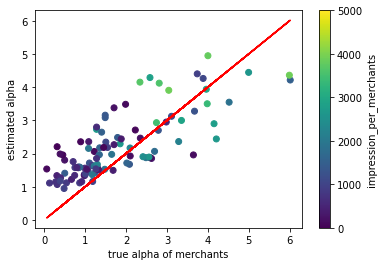

In [16]:
plt.scatter(true_parameters['alpha_i'], alpha_i.mean(),c=impression_per_merchant, cmap='viridis', vmin=0, vmax=5000)
plt.plot(true_parameters['alpha_i'], true_parameters['alpha_i'], color='red')
plt.xlabel('true alpha of merchants')
plt.ylabel('estimated alpha')
plt.colorbar(label='impression_per_merchants')
plt.show()

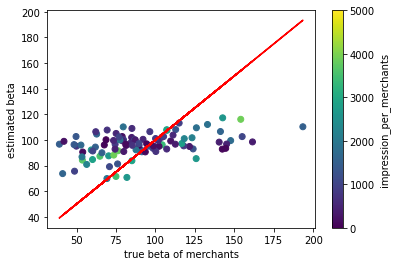

In [17]:
plt.scatter(true_parameters['beta_i'], beta_i.mean(), c=impression_per_merchant, cmap='viridis', vmin=0, vmax=5000)
plt.plot(true_parameters['beta_i'], true_parameters['beta_i'], color='red')
plt.xlabel('true beta of merchants')
plt.ylabel('estimated beta')
plt.colorbar(label='impression_per_merchants')
plt.show()

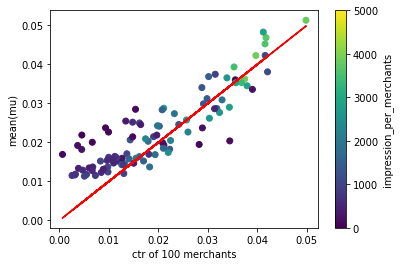

In [18]:
plt.scatter(true_parameters['mu_i'], mu.mean(), c=impression_per_merchant, cmap='viridis', vmin=0, vmax=5000)
plt.plot(true_parameters['mu_i'], true_parameters['mu_i'], color='red')
plt.xlabel('ctr of 100 merchants')
plt.ylabel('mean(mu)')
plt.colorbar(label='impression_per_merchant')
plt.show()

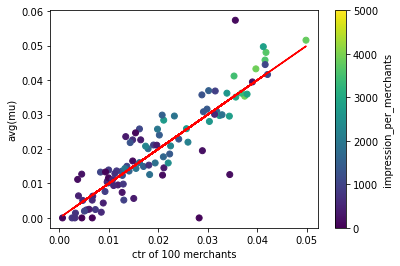

In [19]:
plt.scatter(true_parameters['mu_i'], click_per_merchant/impression_per_merchant, c=impression_per_merchant, cmap='viridis', vmin=0, vmax=5000)
plt.plot(true_parameters['mu_i'], true_parameters['mu_i'], color='red')
plt.xlabel('ctr of 100 merchants')
plt.ylabel('avg(mu)')
plt.colorbar(label='impression_per_merchant')
plt.show()

In [20]:
print('MSE of estimated ctr per merchant', np.square(true_parameters['mu_i']-mu.mean()).mean())
print('MSE of average ctr per merchant', np.square(true_parameters['mu_i']-click_per_merchant/impression_per_merchant).mean())

MSE of estimated ctr per merchants 4.113572603425025e-05
MSE of average ctr per merchants 3.772598925455976e-05


---

Figure 1&2 compares tradional way to compute the ctr with the bayesian way.
The bayesian does better esimate the ctr when the expectation is low.
Intuitively, the prior that baysian gives makes a better fit when our observations is rather low.
Hence we have a default belief about how the good is when we see a new kind.

---

In [21]:
text='''
data{
  int<lower=0> N;
  int<lower=0> M;
  int<lower=1, upper=100> type[N];
  int<lower=0> impression[N];
  int<lower=0> click[N];
}
parameters{
  vector<lower=0.01, upper=1>[M] mu;
  vector<lower=0>[M] trial;
  real<lower=0> alpha_u;
  real<lower=0> beta_u;
}
transformed parameters{
  vector[M] alpha_i;
  vector[M] beta_i;
  alpha_i = mu.*trial;
  beta_i = (1-mu).*trial;
}
model{
  alpha_u~uniform(0.01, 100);
  beta_u~uniform(0.01, 100);
  mu~beta(alpha_u, beta_u);
  trial~gamma(10, 0.1);
  for(i in 1:N) {
    click[i]~beta_binomial(impression[i], alpha_i[type[i]], beta_i[type[i]]);
    impression[i]~poisson(1000*mu[type[i]]+5);
  }
}
'''
stan_data = {'N':data.shape[0], 'M':nmerchants, 'type': list(data[:,0].astype('int')+1), 'impression': list(data[:,2].astype('int')), 'click': list(data[:,3].astype('int'))}
posterior = stan.build(text, data=stan_data)
fit = posterior.sample(num_chains=1, num_samples=500)
df_with_impression = fit.to_frame()

Building...



Building: 48.7s, done.Messages from stanc:
Warning in '/tmp/httpstan_6ekui3hv/model_vpnffd35.stan', line 23, column 23: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_6ekui3hv/model_vpnffd35.stan', line 23, column 17: Argument 0.01 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_6ekui3hv/model_vpnffd35.stan', line 23, column 2: Parameter beta_u is given a uniform distribution. The uniform distribution is not recommended, for two reasons: (a) Except when there are logical or physical constraints, it is very unusual for you to be sure that a parameter will fall inside a specified range, and (b) The infinite gradient induced by a uniform density can cause difficulties for Stan's sampling algorithm. As a consequence, we recommend soft constraints rather than hard constraints; 

In [22]:
df_with_impression.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu.1,mu.2,mu.3,...,beta_i.91,beta_i.92,beta_i.93,beta_i.94,beta_i.95,beta_i.96,beta_i.97,beta_i.98,beta_i.99,beta_i.100
draws,,,,,,,,,,,,,,,,,,,,,
0,289177.216730,0.925061,0.145608,5.0,31.0,0.0,-289083.695226,0.029512,0.013226,0.023879,...,112.548302,65.902561,78.919036,60.232390,150.482548,124.631350,129.325786,103.547889,111.606388,68.224376
1,289162.836228,0.938385,0.145608,4.0,25.0,1.0,-289054.934172,0.030451,0.014008,0.024383,...,122.009980,55.166832,86.016655,89.338821,108.236091,141.937368,106.636362,77.653379,117.098704,60.558118
2,289174.320611,0.939190,0.145608,4.0,17.0,1.0,-289052.659514,0.025892,0.014279,0.025620,...,142.934536,48.250887,73.564731,109.665075,157.888359,88.090681,111.953289,63.070794,76.737599,116.105997
3,289171.948365,0.930059,0.145608,4.0,24.0,1.0,-289065.345014,0.025661,0.014381,0.025454,...,148.513608,58.164906,77.414501,111.128631,186.193740,101.051755,110.357526,71.221658,74.950712,98.239228
4,289180.030787,0.967574,0.145608,4.0,31.0,1.0,-289072.556490,0.025531,0.014694,0.026375,...,148.209179,66.338092,75.194703,110.184880,101.930001,56.369162,130.543802,106.226877,100.430661,94.528756


In [24]:
alpha_u_impression = df_with_impression['alpha_u']
beta_u_impression = df_with_impression['beta_u']
mu_impression = df_with_impression.iloc[:,7:107]
trial_impression = df_with_impression.iloc[:,107:207]
alpha_i_impression = df_with_impression.iloc[:, 209:309]
beta_i_impression = df_with_impression.iloc[:, 309:409]

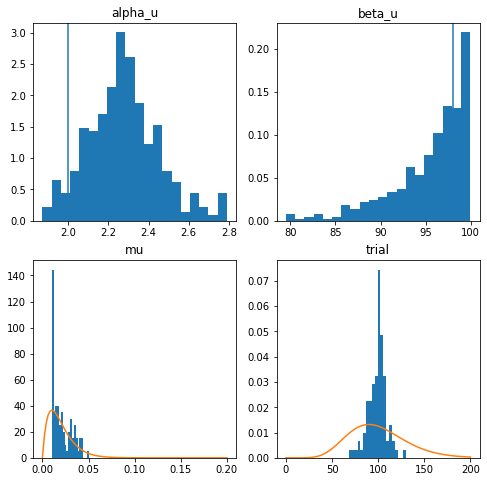

In [25]:
points = np.linspace(0, 100, 1001, endpoint=True)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axes[0,0].set_title('alpha_u')
axes[0,0].hist(alpha_u_impression, density=True, bins=20)
axes[0,0].axvline(2)
axes[0,1].set_title('beta_u')
axes[0,1].hist(beta_u_impression, density=True, bins=20)
axes[0,1].axvline(98)
axes[1,0].set_title('mu')
axes[1,0].hist(mu_impression.mean(), density=True, bins=20)
axes[1,0].plot(np.linspace(0, 0.2, 100), stats.beta.pdf(np.linspace(0, 0.2, 100), 2, 98))
axes[1,1].set_title('trial')
axes[1,1].hist(trial_impression.mean(), density=True, bins=20)
axes[1,1].plot(np.linspace(0, 200, 100), stats.gamma.pdf(np.linspace(0, 200, 100), a=10, scale=10))

In [30]:
customer_stan['alpha_i_imrpession'] = alpha_i_impression.mean()[customer_stan.merchant_id][1]
customer_stan['beta_i_impression'] = beta_i_impression.mean()[customer_stan.merchant_id][1]
customer_stan['avg_stan_impression'] = (customer_stan.click+customer_stan.alpha_i_imrpession)/(customer_stan.impression+customer_stan.alpha_i_imrpession+customer_stan.beta_i_impression)
customer_stan.head()

,merchant_id,ctr,impression,click,alpha_i,beta_i,avg_stan,alpha_i_imrpession,beta_i_impression,avg_stan_impression
0,0,0.010092,34,1,2.463468,102.645478,0.024898,2.94664,99.755342,0.028870
1,0,0.031432,29,0,2.463468,102.645478,0.018369,2.94664,99.755342,0.022374
2,0,0.024963,34,2,2.463468,102.645478,0.032086,2.94664,99.755342,0.036186
3,0,0.024978,34,1,2.463468,102.645478,0.024898,2.94664,99.755342,0.028870
4,0,0.037996,33,0,2.463468,102.645478,0.017837,2.94664,99.755342,0.021714


In [26]:
print('MSE of estimated ctr per merchant', np.square(true_parameters['mu_i']-mu_impression.mean()).mean())
print('MSE of average ctr per merchant', np.square(true_parameters['mu_i']-click_per_merchant/impression_per_merchant).mean())

MSE of estimated ctr per merchants 6.1341661035740825e-06
MSE of average ctr per merchants 3.772598925455976e-05


In [31]:
print('MSE of estimated ctr per good', np.square(customer_stan.ctr-customer_stan.avg_stan_impression).mean())
print('MSE of average ctr per good', np.square(customer_stan.ctr-(customer_stan.click/customer_stan.impression)).mean())

MSE of estimated ctr per goods 0.0003281963329367797
MSE of average ctr per goods 0.0007382361753896118


In [33]:
text='''
data{
  int<lower=0> N;
  int<lower=0> M;
  int<lower=1, upper=100> type[N];
  int<lower=0> impression[N];
  int<lower=0> click[N];
  real<lower=0> alpha_u;
  real<lower=0> beta_u;
}
parameters{
  vector<lower=0.01, upper=1>[M] mu;
  vector<lower=0>[M] trial;
}
transformed parameters{
  vector[M] alpha_i;
  vector[M] beta_i;
  alpha_i = mu.*trial;
  beta_i = (1-mu).*trial;
}
model{
  mu~beta(alpha_u, beta_u);
  trial~gamma(10, 0.1);
  for(i in 1:N) {
    click[i]~beta_binomial(impression[i], alpha_i[type[i]], beta_i[type[i]]);
  }
}
'''
stan_data = {'N':data.shape[0], 'M':nmerchants, 'type': list(data[:,0].astype('int')+1), 'impression': list(data[:,2].astype('int')), 'click': list(data[:,3].astype('int')), 'alpha_u': alpha_u.mean(), 'beta_u': beta_u.mean()}
posterior = stan.build(text, data=stan_data)
fit = posterior.sample(num_chains=1, num_samples=500)
df = fit.to_frame()

Building...



Building: 44.0s, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/1500)
Sampling:   7% (100/1500)
Sampling:  13% (200/1500)
Sampling:  20% (300/1500)
Sampling:  27% (400/1500)
Sampling:  33% (500/1500)
Sampling:  40% (600/1500)
Sampling:  47% (700/1500)
Sampling:  53% (800/1500)
Sampling:  60% (900/1500)
Sampling:  67% (1000/1500)
Sampling:  67% (1001/1500)
Sampling:  73% (1100/1500)
Sampling:  80% (1200/1500)
Sampling:  87% (1300/1500)
Sampling:  93% (1400/1500)
Sampling: 100% (1500/1500)
Sampling: 100% (1500/1500), done.
Messages received during sampling:
  Gradient evaluation took 0.003219 seconds
  1000 transitions using 10 leapfrog steps per transition would take 32.19 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_binomial_lpmf: First prior sample size parameter is inf, but must be positive finite! (in '/tmp/httpstan_navh0bt4/model_ngw6cd

In [34]:
df.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu.1,mu.2,mu.3,...,beta_i.91,beta_i.92,beta_i.93,beta_i.94,beta_i.95,beta_i.96,beta_i.97,beta_i.98,beta_i.99,beta_i.100
draws,,,,,,,,,,,,,,,,,,,,,
0,-12895.256815,0.990711,0.209122,4.0,15.0,0.0,12986.263353,0.018453,0.011893,0.033876,...,61.109001,55.180799,112.437104,76.848820,70.001790,79.415654,103.190670,116.772851,114.262350,107.833088
1,-12912.994753,0.748646,0.209122,4.0,15.0,0.0,13003.201786,0.036674,0.011334,0.019416,...,156.628905,108.850819,36.102963,137.112676,106.306655,54.295570,63.630792,85.376144,73.017356,117.581266
2,-12906.825953,1.000000,0.209122,4.0,15.0,0.0,12999.594692,0.017759,0.013806,0.020331,...,100.464648,87.138723,205.998457,87.863042,102.773659,62.867603,73.853439,127.318710,65.701800,85.844831
3,-12915.025165,0.945735,0.209122,4.0,15.0,0.0,13023.165263,0.033920,0.010757,0.031586,...,99.078977,133.285808,62.575618,56.140496,78.986830,115.906940,52.955869,58.507486,144.845684,153.861320
4,-12915.206929,0.986382,0.209122,4.0,15.0,0.0,13018.823863,0.015533,0.013809,0.023619,...,69.660224,91.904905,177.140458,37.412692,134.595245,74.477017,80.838395,73.601820,82.572624,85.284372


In [36]:
mu_prior = df.iloc[:,7:107]
trial_prior = df.iloc[:,107:207]
alpha_i_prior = df.iloc[:, 207:307]
beta_i_prior = df.iloc[:, 307:407]

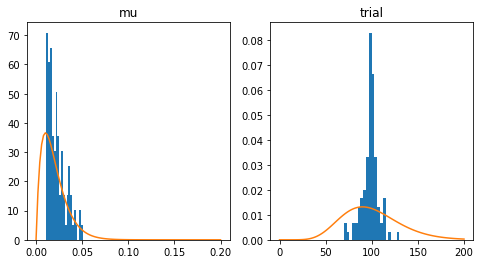

In [41]:
points = np.linspace(0, 100, 1001, endpoint=True)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes[0].set_title('mu')
axes[0].hist(mu_prior.mean(), density=True, bins=20)
axes[0].plot(np.linspace(0, 0.2, 100), stats.beta.pdf(np.linspace(0, 0.2, 100), 2, 98))
axes[1].set_title('trial')
axes[1].hist(trial_prior.mean(), density=True, bins=20)
axes[1].plot(np.linspace(0, 200, 100), stats.gamma.pdf(np.linspace(0, 200, 100), a=10, scale=10))

In [42]:
customer_stan['alpha_i_prior'] = alpha_i_prior.mean()[customer_stan.merchant_id][1]
customer_stan['beta_i_prior'] = beta_i_prior.mean()[customer_stan.merchant_id][1]
customer_stan = customer_stan.assign(avg_stan_prior = lambda df:(df.click+df.alpha_i_prior)/(df.impression+df.alpha_i_prior+df.beta_i_prior))
customer_stan.head()

,merchant_id,ctr,impression,click,alpha_i,beta_i,avg_stan,alpha_i_imrpession,beta_i_impression,avg_stan_impression,alpha_i_prior,beta_i_prior,avg_stan_prior
0,0,0.010092,34,1,2.463468,102.645478,0.024898,2.94664,99.755342,0.028870,2.284246,99.362911,0.024212
1,0,0.031432,29,0,2.463468,102.645478,0.018369,2.94664,99.755342,0.022374,2.284246,99.362911,0.017484
2,0,0.024963,34,2,2.463468,102.645478,0.032086,2.94664,99.755342,0.036186,2.284246,99.362911,0.031584
3,0,0.024978,34,1,2.463468,102.645478,0.024898,2.94664,99.755342,0.028870,2.284246,99.362911,0.024212
4,0,0.037996,33,0,2.463468,102.645478,0.017837,2.94664,99.755342,0.021714,2.284246,99.362911,0.016965


In [44]:
print('MSE of estimated ctr per merchants', np.square(true_parameters['mu_i']-mu_prior.mean()).mean())
print('MSE of average ctr per merchants', np.square(true_parameters['mu_i']-click_per_merchants/impression_per_merchants).mean())
print('MSE of estimated ctr per goods', np.square(customer_stan.ctr-customer_stan.avg_stan_prior).mean())
print('MSE of average ctr per goods', np.square(customer_stan.ctr-(customer_stan.click/customer_stan.impression)).mean())

MSE of estimated ctr per merchants 3.929199397204216e-05
MSE of average ctr per merchants 3.772598925455976e-05
MSE of estimated ctr per goods 0.0002677925401455942
MSE of average ctr per goods 0.0007382361753896118



---

If we neglect the difference between merchants:

$ctr_i\sim Betabinomial(impression_i, \alpha,\beta)$

---

In [45]:
text2='''
data{
  int<lower=0> N;
  int<lower=0> impression[N];
  int<lower=0> click[N];
}
parameters{
  real<lower=0> alpha;
  real<lower=0> beta;
}
model{
  alpha~uniform(0.01, 100);
  beta~uniform(0.01, 100);
  click~beta_binomial(impression, alpha, beta);
}
'''
stan_data = {'N':data.shape[0], 'impression': list(data[:,2].astype('int')), 'click': list(data[:,3].astype('int'))}
posterior = stan.build(text2, data=stan_data)
fit = posterior.sample(num_chains=1, num_samples=500)
df_nomerchant = fit.to_frame()

Building...



Building: 30.9s, done.Messages from stanc:
Warning in '/tmp/httpstan_o0x7xy_w/model_mrjqfvrf.stan', line 13, column 21: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_o0x7xy_w/model_mrjqfvrf.stan', line 13, column 15: Argument 0.01 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_o0x7xy_w/model_mrjqfvrf.stan', line 13, column 2: Parameter beta is given a uniform distribution. The uniform distribution is not recommended, for two reasons: (a) Except when there are logical or physical constraints, it is very unusual for you to be sure that a parameter will fall inside a specified range, and (b) The infinite gradient induced by a uniform density can cause difficulties for Stan's sampling algorithm. As a consequence, we recommend soft constraints rather than hard constraints; fo

In [46]:
df_nomerchant.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta
draws,,,,,,,,,
0,-15461.571749,0.882488,0.208336,4.0,19.0,0.0,15463.769887,1.391558,53.664793
1,-15461.497371,0.870892,0.208336,4.0,19.0,0.0,15463.732497,1.557488,62.851166
2,-15462.664992,0.868636,0.208336,2.0,7.0,0.0,15463.744739,1.561485,59.113294
3,-15464.711356,0.588601,0.208336,1.0,1.0,0.0,15464.896077,1.574003,58.516310
4,-15468.150280,0.408542,0.208336,1.0,1.0,0.0,15468.669688,1.597850,58.136727


In [54]:
customer_stan['alpha_nomerchant'] = df_nomerchant.alpha.mean()
customer_stan['beta_nomerchant'] = df_nomerchant.beta.mean()
customer_stan = customer_stan.assign(avg_stan_nomerchant = lambda df:(df.click+df.alpha_nomerchant)/(df.impression+df.alpha_nomerchant+df.beta_nomerchant))
customer_stan.head()

,merchant_id,ctr,impression,click,alpha_i,beta_i,avg_stan,alpha_i_imrpession,beta_i_impression,avg_stan_impression,alpha_i_prior,beta_i_prior,avg_stan_prior,avg_bayesian,alpha_nomerchant,beta_nomerchant,avg_stan_nomerchant
0,0,0.010092,34,1,2.463468,102.645478,0.024898,2.94664,99.755342,0.028870,2.284246,99.362911,0.024212,0.026383,1.47479,58.327998,0.026383
1,0,0.031432,29,0,2.463468,102.645478,0.018369,2.94664,99.755342,0.022374,2.284246,99.362911,0.017484,0.016607,1.47479,58.327998,0.016607
2,0,0.024963,34,2,2.463468,102.645478,0.032086,2.94664,99.755342,0.036186,2.284246,99.362911,0.031584,0.037044,1.47479,58.327998,0.037044
3,0,0.024978,34,1,2.463468,102.645478,0.024898,2.94664,99.755342,0.028870,2.284246,99.362911,0.024212,0.026383,1.47479,58.327998,0.026383
4,0,0.037996,33,0,2.463468,102.645478,0.017837,2.94664,99.755342,0.021714,2.284246,99.362911,0.016965,0.015892,1.47479,58.327998,0.015892


(array([0.00360274, 0.00180137, 0.00540412, 0.01441098, 0.03062332,
        0.06484939, 0.07385625, 0.09367135, 0.09367135, 0.12069193,
        0.09367135, 0.07385625, 0.05404116, 0.0576439 , 0.0324247 ,
        0.0324247 , 0.02341784, 0.01080823, 0.0126096 , 0.00720549]),
 array([47.3630695 , 48.47333432, 49.58359915, 50.69386397, 51.80412879,
        52.91439362, 54.02465844, 55.13492326, 56.24518809, 57.35545291,
        58.46571774, 59.57598256, 60.68624738, 61.79651221, 62.90677703,
        64.01704185, 65.12730668, 66.2375715 , 67.34783632, 68.45810115,
        69.56836597]),
 <a list of 20 Patch objects>)

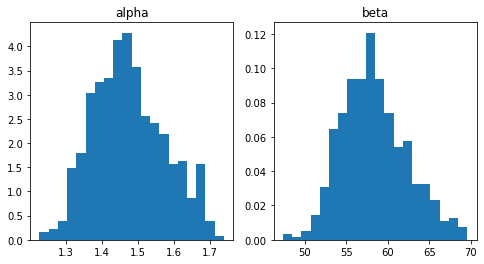

In [58]:
points = np.linspace(0, 100, 1001, endpoint=True)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes[0].set_title('alpha')
axes[0].hist(df_nomerchant.alpha, density=True, bins=20)
axes[1].set_title('beta')
axes[1].hist(df_nomerchant.beta, density=True, bins=20)

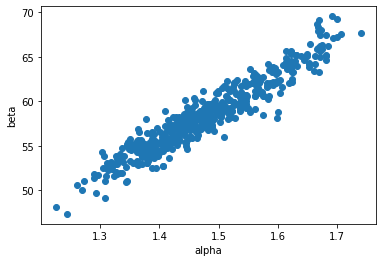

In [61]:
plt.scatter(df_nomerchant.alpha, df_nomerchant.beta)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.show()

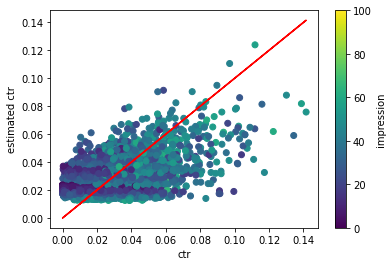

In [56]:
plt.scatter(customer_stan.ctr, customer_stan.avg_stan_nomerchant, c=customer_stan.impression, cmap='viridis', vmin=0, vmax=100)
plt.plot(customer_stan.ctr, customer_stan.ctr, color='red')
plt.colorbar(label='impression')
plt.xlabel('ctr')
plt.ylabel('estimated ctr')
plt.show()

___

Compare MSE of 5 models which are
1. raw mean
2. empirical bayes with merchants
3. empirical bayes without merchants
4. empirical bayes with merchants and with given alpha_u and beta_u
5. empirical bayes with merchants and impression distribution
___

In [64]:
# per good basis
print(np.square(customer_stan.ctr-(customer_stan.click/customer_stan.impression)).mean(), ' MSE of raw mean per good', sep=',')
print(np.square(customer_stan.ctr-customer_stan.avg_stan).mean(), ' MSE of EB with merchants per good', sep=',')
print(np.square(customer_stan.ctr-customer_stan.avg_stan_nomerchant).mean(), ' MSE of EB without merchants per good', sep=',')
print(np.square(customer_stan.ctr-customer_stan.avg_stan_prior).mean(), ' MSE of EB with merchants and given prior', sep=',')
print(np.square(customer_stan.ctr-customer_stan.avg_stan_impression).mean(), ' MSE of EB with merchants and impression distribution per good', sep=',')

0.0007382361753896118, MSE of raw mean per good
0.00027531502470522337, MSE of EB with merchants per good
0.00026556393544481717, MSE of EB without merchants per good
0.0002677925401455942, MSE of EB with merchants and given prior
0.0003281963329367797, MSE of EB with merchants and impression distribution per good


In [68]:
# per merchant basis, ramind that without merchants model cannot be calculated
print(np.square(true_parameters['mu_i']-click_per_merchant/impression_per_merchant).mean(), ' MSE of raw mean per merchant', sep=',')
print(np.square(true_parameters['mu_i']-mu.mean()).mean(), ' MSE of EB with merchants per merchant', sep=',')
print(np.square(true_parameters['mu_i']-mu_impression.mean()).mean(), ' MSE of EB with merchants and impression distribution per merchant', sep=',')
print(np.square(true_parameters['mu_i']-mu_prior.mean()).mean(), ' MSE of EB with merchants and given prior per merchant', sep=',')

3.772598925455976e-05, MSE of raw mean per merchant
4.113572603425025e-05, MSE of EB with merchants per merchant
6.1341661035740825e-06, MSE of EB with merchants and impression distribution per merchant
3.929199397204216e-05, MSE of EB with merchants and given prior per merchant


---

Consider another model where merchants difference exists but with same trial, which is called beta-binomial regression.

$\mu_i\sim Beta(\alpha_u, \beta_u)\\
trial_i = c,\ ∀i$

With parameter tranformation: $\alpha_i=\mu_i*c,\ \beta_i=(1-\mu_i)*c$

The relation between datas and parameters:

$ctr_{ij}\sim Beta(\alpha_i, \beta_i)\\
click_{ij}\sim Bin(impression_{ij}, ctr_{ij})$

---

In [ ]:
text3='''
data{
  int<lower=0> N;
  int<lower=0> M;
  int<lower=1, upper=100> type[N];
  int<lower=0> impression[N];
  int<lower=0> click[N];
}
parameters{
  vector<lower=0.01, upper=1>[M] mu;
  real<lower=0> trial;
  real<lower=0> alpha_u;
  real<lower=0> beta_u;
}
transformed parameters{
  vector[M] alpha_i;
  vector[M] beta_i;
  alpha_i = mu*trial;
  beta_i = (1-mu)*trial;
}
model{
  alpha_u~uniform(0.01, 100);
  beta_u~uniform(0.01, 100);
  mu~beta(alpha_u, beta_u);
  trial~gamma(10, 0.1);
  for(i in 1:N) {
    click[i]~beta_binomial(impression[i], alpha_i[type[i]], beta_i[type[i]]);
  }
}
'''
stan_data = {'N':data.shape[0], 'M':nmerchants, 'type': list(data[:,0].astype('int')+1), 'impression': list(data[:,2].astype('int')), 'click': list(data[:,3].astype('int'))}
posterior = stan.build(text3, data=stan_data)
fit = posterior.sample(num_chains=1, num_samples=500)
df_same_trial = fit.to_frame()

Building...



Building: 41.6s, done.Messages from stanc:
Warning in '/tmp/httpstan_i6gdw5av/model_uwba3zav.stan', line 23, column 23: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_i6gdw5av/model_uwba3zav.stan', line 23, column 17: Argument 0.01 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_i6gdw5av/model_uwba3zav.stan', line 23, column 2: Parameter beta_u is given a uniform distribution. The uniform distribution is not recommended, for two reasons: (a) Except when there are logical or physical constraints, it is very unusual for you to be sure that a parameter will fall inside a specified range, and (b) The infinite gradient induced by a uniform density can cause difficulties for Stan's sampling algorithm. As a consequence, we recommend soft constraints rather than hard constraints; 

In [ ]:
df_same_trial.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu.1,mu.2,mu.3,...,beta_i.91,beta_i.92,beta_i.93,beta_i.94,beta_i.95,beta_i.96,beta_i.97,beta_i.98,beta_i.99,beta_i.100
draws,,,,,,,,,,,,,,,,,,,,,
0,-24927.537044,1.000000,0.120568,5.0,31.0,0.0,24973.092559,0.061780,0.050863,0.013517,...,29.311330,29.257566,29.317336,28.617997,28.852931,29.415187,29.325427,28.253701,29.513480,29.084331
1,-24932.604968,0.978426,0.120568,5.0,31.0,0.0,24977.977854,0.038029,0.045738,0.014149,...,28.131187,28.185273,28.171607,27.672624,27.770403,28.198100,28.013232,27.234283,28.276100,27.861035
2,-24932.687603,0.999851,0.120568,5.0,31.0,0.0,24983.105084,0.043577,0.036436,0.013468,...,27.067052,26.912223,26.771894,26.569635,26.834602,27.091921,26.990930,25.602380,26.963185,26.643787
3,-24933.893555,0.919702,0.120568,3.0,13.0,1.0,24987.979546,0.052340,0.038466,0.014138,...,27.497787,27.495010,27.258357,26.950446,27.351654,27.573399,27.354085,26.139872,27.458503,27.188791
4,-24936.810450,0.831477,0.120568,2.0,7.0,1.0,24994.413300,0.054121,0.036439,0.014882,...,27.713703,27.904503,27.657610,27.387159,27.771993,27.996290,27.712666,26.627247,27.880722,27.606426


In [ ]:
mu2 = df_same_trial.iloc[:,7:107].mean()
alpha_proun = df_same_trial.iloc[:,107].mean()*mu2
beta_proun = df_same_trial.iloc[:,107].mean()-alpha_proun

In [ ]:
customer_stan['alpha_proun'] = alpha_proun[customer_stan.merchant_id][1]
customer_stan['beta_proun'] = beta_proun[customer_stan.merchant_id][1]
customer_stan = customer_stan.assign(avg_uni_trial = lambda df:(df.click+df.alpha_proun)/(df.impression+df.alpha_proun+df.beta_proun))
customer_stan.head()

,merchant_id,ctr,impression,click,alpha_i,beta_i,avg_stan,avg_bayesian,alpha_proun,beta_proun,avg_uni_trial
0,0,0.039671,36,3,3.548383,95.567618,0.048465,0.049453,1.189672,27.562866,0.064703
1,0,0.024390,67,3,3.548383,95.567618,0.039421,0.035534,1.189672,27.562866,0.043755
2,0,0.046245,39,4,3.548383,95.567618,0.054652,0.059820,1.189672,27.562866,0.076597
3,0,0.022885,37,1,3.548383,95.567618,0.033415,0.023881,1.189672,27.562866,0.033302
4,0,0.039725,88,3,3.548383,95.567618,0.034996,0.029844,1.189672,27.562866,0.035885


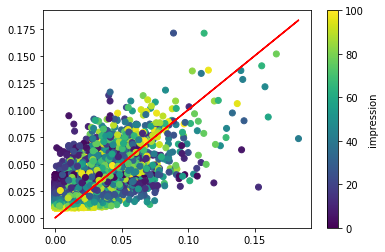

In [ ]:
plt.scatter(customer_stan.ctr, customer_stan.avg_uni_trial, c=customer_stan.impression, cmap='viridis', vmin=0, vmax=100)
plt.plot(customer_stan.ctr, customer_stan.ctr, color='red')
plt.colorbar(label='impression')
plt.show()